# Brain Tumor Detection

## 1.0 Project Overview and Objectives

This project aimed to build a CNN model for tumor classification based on MRI scans. Three different architectures (custom CNN, VGG-16, and ResNet) were compared using accuracy as the primary metric for model performance. The dataset was preprocessed, models were trained and evaluated, and hyperparameter tuning techniques may have been used. The goal was to identify the most effective model for accurately classifying tumor and non-tumor subjects.

### 1.1 Data Set Description

The project utilized the [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection) dataset, which consists of MRI scans categorized into two classes:

- **NO**: Represents scans with no tumor, encoded as 0.
- **YES**: Represents scans with tumors, encoded as 1.

However, it is important to note that the dataset lacks specific information regarding the origin and other related details of the MRI scans.


### 1.2 What is a Brain Tumor?

> A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur. <figure class="image"> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Hirnmetastase_MRT-T1_KM.jpg/300px-Hirnmetastase_MRT-T1_KM.jpg"><figcaption>Brain metastasis in the right cerebral hemisphere from lung cancer, shown on magnetic resonance imaging.</figcaption>
</figure>



Source: [Wikipedia](https://www.wikiwand.com/en/Brain_tumor)

## 2.0 Setting Up the Enviroment

### 2.1 Import Modules

In [34]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import torchvision
import torch
import shutil
import imutils
from PIL import Image
from keras.models import Sequential
from keras import layers
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input


In [7]:
!unzip "archive (1).zip"

Archive:  archive (1).zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_dataset/no/28 no.jpg  
  inflating: b

### 2.2 Rename image labels

This script renames the 'yes' and 'no' folders to ensure consistent naming for the images. Additionally, it standardizes the image format for all files.

In [10]:
def rename_images(dir_path, prefix):
    # For each item in the directory
    for item in os.scandir(dir_path):
        # Initialize the counter
        counter = 1
        if item.is_dir():
            # If the item is a directory, recursively call the function
            rename_images(item.path, prefix)
        else:
            # Convert the file extension to lowercase
            filename, extension = os.path.splitext(item.path)
            extension = extension.lower()

            # If the file has an image extension
            if extension in ['.png', '.jpg', '.jpeg', '.gif']:
                # Replace '.jpeg' with '.jpg'
                if extension == '.jpeg':
                    extension = '.jpg'

                # Create the new filename
                new_filename = prefix + str(counter) + extension
                # Create the new file path
                new_file_path = os.path.join(dir_path, new_filename)

                # Check if the file already exists
                while os.path.exists(new_file_path):
                    # Increment the counter and try again
                    counter += 1
                    new_filename = prefix + str(counter) + extension
                    new_file_path = os.path.join(dir_path, new_filename)

                # Rename the file
                os.rename(item.path, new_file_path)

    print(f"Renamed images in directory {dir_path}")


In [11]:
# Define the folders where the images are located
dir_path_no = './raw/no/'
dir_path_yes = './raw/yes/'

# Call function for both directories
rename_images(dir_path_no, "N")
rename_images(dir_path_yes, "Y")

Renamed images in directory ./raw/no/
Renamed images in directory ./raw/yes/


### 2.3 Train, Validation and Test Split

We are about to segregate the contents of the main folder into three distinct subsets, namely: `TRAIN`, `VALIDATION`, and `TEST`. This partitioning will be performed according to predefined percentage allocations. Consequently, this process will yield a restructured folder system, with each subset - `TRAIN`, `VALIDATION`, and `TEST` - organized into separate directories. Within each of these directories, you'll find an inclusive mix of 'yes' and 'no' samples, providing a diverse set of data for each subset.

In [12]:
# Path to the original data directory
original_dataset_dir = './raw'

# Proportions for train, validation, and test
train_size = 0.7
val_size = 0.15
test_size = 0.15

categories = ['yes', 'no']
dirs = ['train', 'val', 'test']

# Create a new 'data' directory
os.makedirs('data', exist_ok=True)

# Create new directories inside 'data' directory
for dir in dirs:
    for category in categories:
        os.makedirs(os.path.join('data', dir, category), exist_ok=True)

# Split the data and copy it in the new directories
for category in categories:
    src_dir = os.path.join(original_dataset_dir, category)
    all_files = os.listdir(src_dir)

    np.random.shuffle(all_files)

    train_files = all_files[:int(len(all_files)*train_size)]
    val_files = all_files[int(len(all_files)*train_size):int(len(all_files)*(train_size+val_size))]
    test_files = all_files[int(len(all_files)*(train_size+val_size)):]

    for file in train_files:
        shutil.copy(os.path.join(src_dir, file), os.path.join('data', 'train', category, file))
    for file in val_files:
        shutil.copy(os.path.join(src_dir, file), os.path.join('data', 'val', category, file))
    for file in test_files:
        shutil.copy(os.path.join(src_dir, file), os.path.join('data', 'test', category, file))


In [13]:
# Root dir
root_dir = './data'
base_dirs = ['train', 'val', 'test']
categories = ['yes', 'no']

# Initialize dictionary to hold counts
counts = {base_dir: {category: 0 for category in categories} for base_dir in base_dirs}

# Create directories if they don't exist and count images in each directory
for base_dir in base_dirs:
    for category in categories:
        dir_path = os.path.join(root_dir, base_dir, category)

        # Create directories if they don't exist
        os.makedirs(dir_path, exist_ok=True)

        num_files = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        counts[base_dir][category] = num_files

# Print counts in a nice format
for base_dir, categories in counts.items():
    print(f"{base_dir.capitalize()} set:")
    for category, count in categories.items():
        print(f"  {category.capitalize()}: {count} images")
    print()

Train set:
  Yes: 108 images
  No: 68 images

Val set:
  Yes: 23 images
  No: 15 images

Test set:
  Yes: 24 images
  No: 15 images



Now the folders are seperated we can retrieve the images in each folder.

In [14]:
def load_data(dir_path):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()


    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [15]:
X_train, Y_train, labels = load_data("./data/train/")
X_val, Y_val, _ = load_data("./data/val/")
X_test, Y_test, _ = load_data("./data/test/")

100%|██████████| 2/2 [00:00<00:00,  3.86it/s]
<ipython-input-14-e92979909939>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


176 images loaded from ./data/train/ directory.


100%|██████████| 2/2 [00:00<00:00, 23.00it/s]


38 images loaded from ./data/val/ directory.


100%|██████████| 2/2 [00:00<00:00, 21.60it/s]


39 images loaded from ./data/test/ directory.


In [16]:
def plot_images(X, y, labels, num_images=5):
    """
    Plot a certain number of images from each category
    """
    fig, axs = plt.subplots(len(labels), num_images, figsize=(15, 15))

    for i, label in labels.items():
        imgs = X[y == i]
        for j in range(num_images):
            if j < len(imgs):
                axs[i, j].imshow(cv2.cvtColor(imgs[j], cv2.COLOR_BGR2RGB))
                axs[i, j].axis('off')
            else:
                axs[i, j].remove()

        # Add title at the top of each row
        axs[i, num_images // 2].set_title(label, fontsize=16)

    plt.tight_layout()
    plt.show()

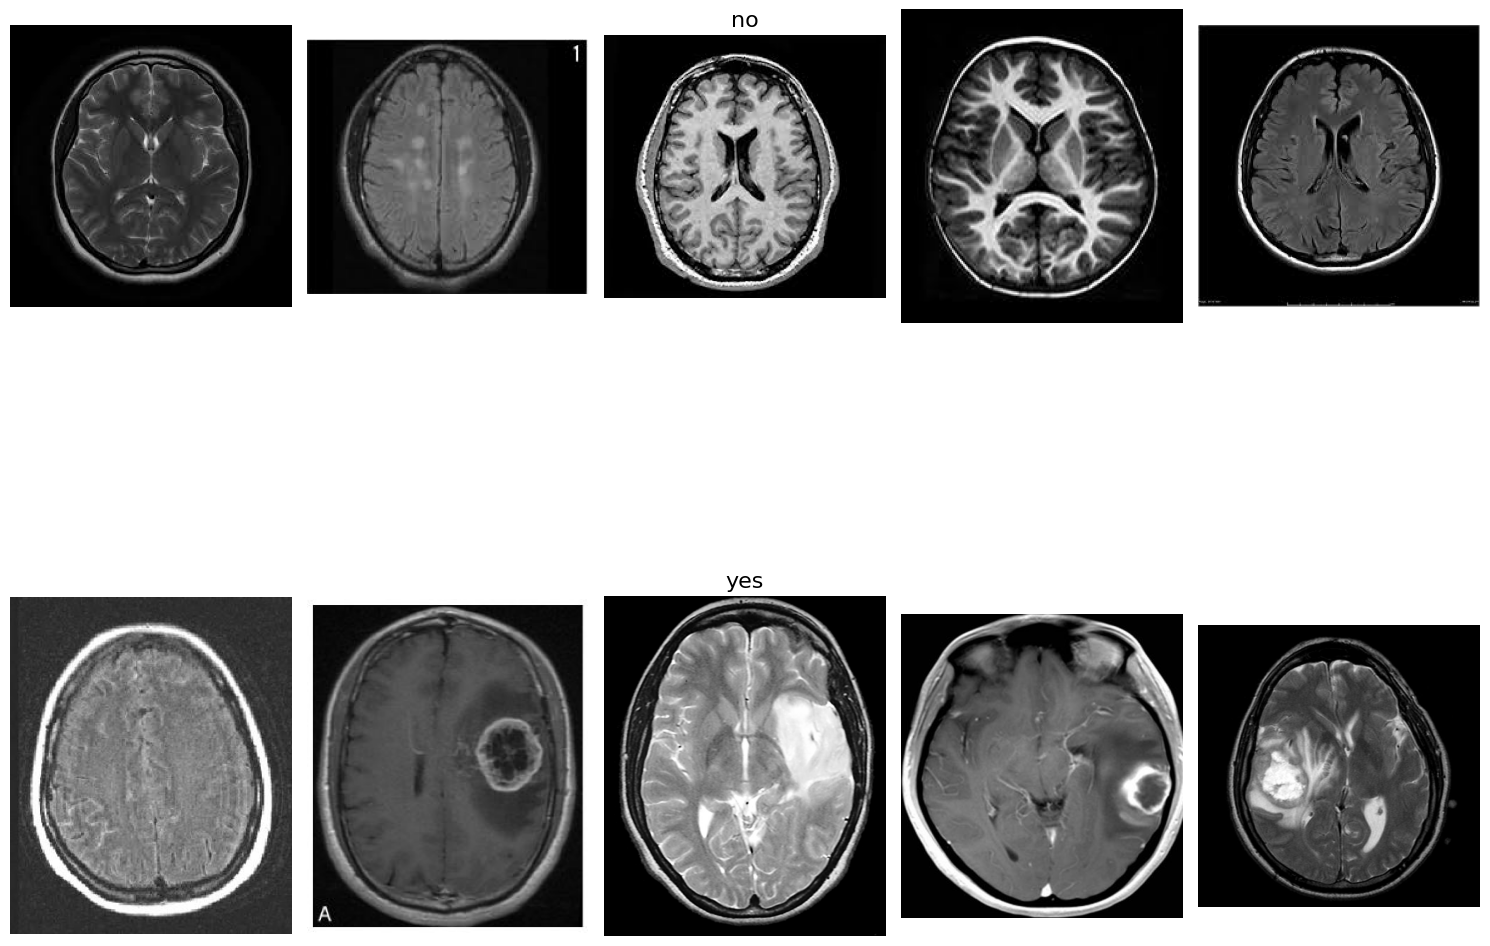

In [17]:
plot_images(X_train, Y_train, labels, 5)

There is substantial inconsistency in our image sizes, compounded by an abundance of irrelevant black spaces. This variability largely stems from the disparate sources of the images. To be compatible with the VGG-16 model, we require images to meet specific dimensions of `(224, 224, 3)` for the input layer.

In [18]:

def plot_image_sizes(X_train, X_val, X_test):
    """
    Plot the distribution of image sizes in the dataset.
    """
    # Combine all datasets
    X = np.concatenate((X_train, X_val, X_test), axis=0)

    widths = [img.shape[1] for img in X]
    heights = [img.shape[0] for img in X]
    aspect_ratios = [width / height for width, height in zip(widths, heights)]

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    axs[0].hist(widths, bins=20, color='skyblue', edgecolor='black')
    axs[0].set_title('Image Widths')
    axs[0].set_xlabel("Pixels")
    axs[0].set_ylabel("Count")

    axs[1].hist(heights, bins=20, color='skyblue', edgecolor='black')
    axs[1].set_title('Image Heights')
    axs[1].set_xlabel("Pixels")
    axs[1].set_ylabel("Count")

    axs[2].hist(aspect_ratios, bins=20, color='skyblue', edgecolor='black')
    axs[2].set_title('Image Aspect Ratios (Width / Height)')
    axs[2].set_xlabel("Pixels")
    axs[2].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

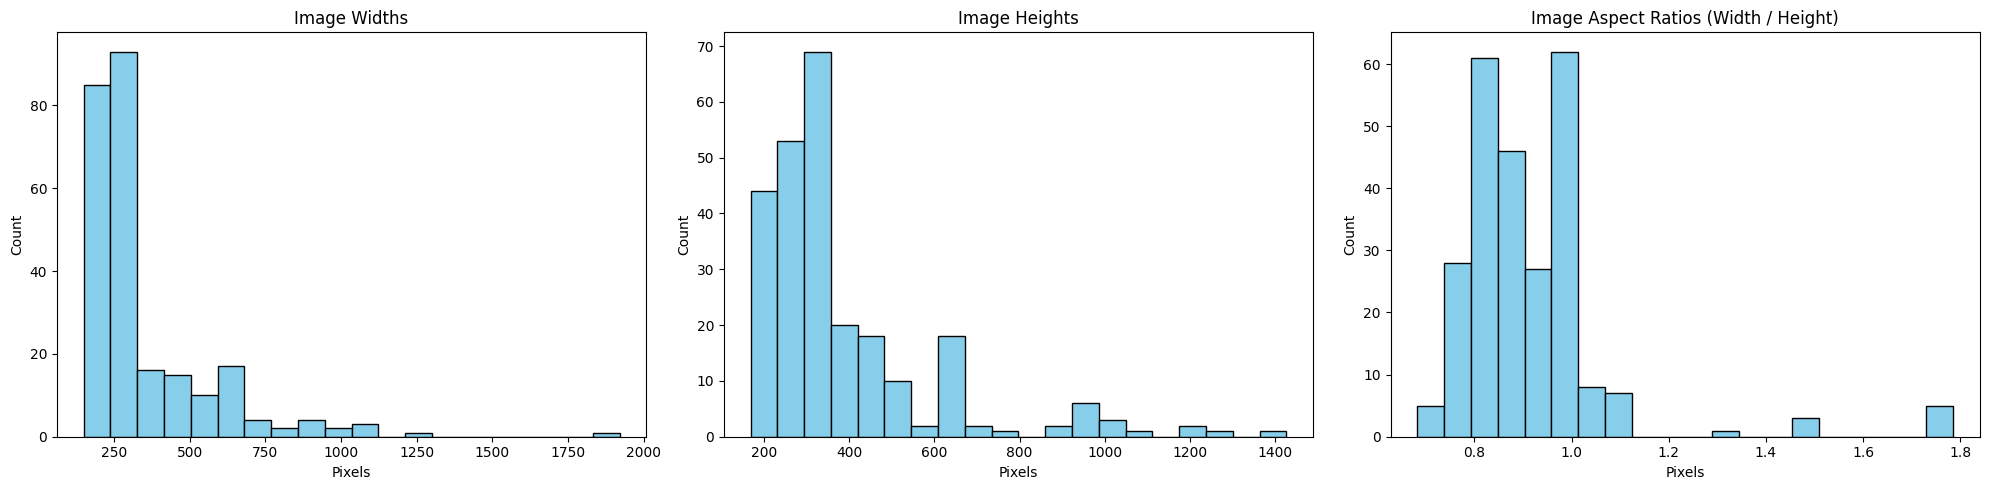

In [19]:
plot_image_sizes(X_train, X_val, X_test)

### 2.4 Image Processing

To begin the process of "normalization," the first step involves cropping the brain out of the images. This critical step ensures that only the relevant portion of the image, the brain itself, is used for further analysis and processing.

In order to accomplish this, a technique described in detail in the [pyimagesearch](https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog was employed. This technique offers a comprehensive explanation and implementation guide, making it highly recommended for anyone seeking a deeper understanding. By referring to this resource, you can gain valuable insights and techniques for effectively cropping the brain from the images.

Overall, the normalization process involves cropping the brain out of the images, and the pyimagesearch blog provides an excellent resource to explore and learn more about this technique in detail.

In [25]:
# Load the image, convert it to grayscale, and blur it slightly
im = cv2.imread('./data/train/yes/Y1.jpg')
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# Threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# Find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# Determine the most extreme points along the contour
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# Draw the outline of the object
contour_image = cv2.drawContours(im.copy(), [c], -1, (0, 255, 255), 2)

# Crop the image based on extreme points
cropped_image = im[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Plotting original image
ax[0, 0].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
ax[0, 0].set_title('Original Image')

# Plotting grayscale image
ax[0, 1].imshow(gray, cmap='gray')
ax[0, 1].set_title('Grayscale Image')

# Plotting thresholded image
ax[0, 2].imshow(thresh, cmap='gray')
ax[0, 2].set_title('Thresholded Image')

# Plotting the image with the largest contour
ax[1, 0].imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
ax[1, 0].set_title('Image with Largest Contour')

# Plotting the image with the extreme points
ax[1, 1].imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
ax[1, 1].scatter([extLeft[0], extRight[0], extTop[0], extBot[0]],
                 [extLeft[1], extRight[1], extTop[1], extBot[1]], color='red')
ax[1, 1].set_title('Image with Extreme Points')

# Plotting the cropped image
ax[1, 2].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
ax[1, 2].set_title('Cropped Image')

plt.tight_layout()
plt.show()


error: ignored

In [26]:
def crop_images(directory_path):
    # Append "**/*" to the end of directory_path to get all subdirectories and files.
    for filename in tqdm(glob.glob(directory_path + '**/*.jpg', recursive=True)):
        # Check if path is a file.
        if os.path.isfile(filename):
            # Open image file using PIL
            try:
                with Image.open(filename) as img:
                    # Load the image, convert it to grayscale, and blur it slightly
                    im = cv2.imread(filename)
                    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                    gray = cv2.GaussianBlur(gray, (5, 5), 0)

                    # Threshold the image, then perform a series of erosions +
                    # dilations to remove any small regions of noise
                    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
                    thresh = cv2.erode(thresh, None, iterations=2)
                    thresh = cv2.dilate(thresh, None, iterations=2)

                    # Find contours in thresholded image, then grab the largest one
                    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    cnts = imutils.grab_contours(cnts)
                    c = max(cnts, key=cv2.contourArea)

                    # Determine the most extreme points along the contour
                    extLeft = tuple(c[c[:, :, 0].argmin()][0])
                    extRight = tuple(c[c[:, :, 0].argmax()][0])
                    extTop = tuple(c[c[:, :, 1].argmin()][0])
                    extBot = tuple(c[c[:, :, 1].argmax()][0])

                    # Draw the outline of the object
                    contour_image = cv2.drawContours(im.copy(), [c], -1, (0, 255, 255), 2)

                    # Crop the image based on extreme points
                    cropped_image = im[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

                    # Save (and thereby overwrite) the image
                    cv2.imwrite(filename, cropped_image)

            except IOError:
                print(f'Could not read file: {filename} - It might not be a valid image file.')
                continue

In [27]:
crop_images("./data/")

100%|██████████| 251/251 [00:02<00:00, 106.76it/s]


100%|██████████| 2/2 [00:00<00:00,  4.81it/s]
<ipython-input-14-e92979909939>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


176 images loaded from ./data/train/ directory.


100%|██████████| 2/2 [00:00<00:00, 27.27it/s]


38 images loaded from ./data/val/ directory.


100%|██████████| 2/2 [00:00<00:00, 25.41it/s]


39 images loaded from ./data/test/ directory.


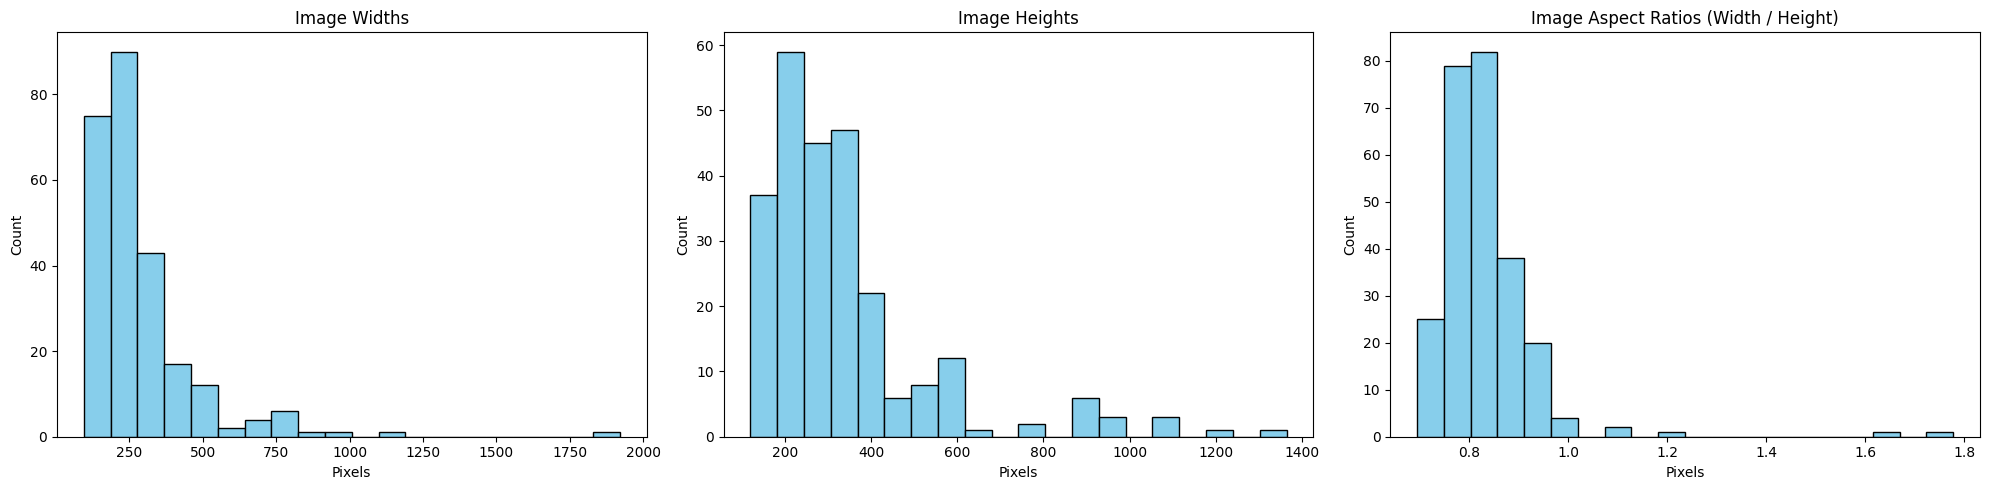

In [28]:
X_train, Y_train, labels = load_data("./data/train/")
X_val, Y_val, _ = load_data("./data/val/")
X_test, Y_test, _ = load_data("./data/test/")
plot_image_sizes(X_train, X_val, X_test)

Now that the images are cropped we can prepare out images for VGG-16 by resizing images to `(224, 224, 3)`.

In [29]:
def resize_images(image_directory, target_size):
    image_filepaths = glob.glob(image_directory + '/**/*.jpg', recursive=True)  # Modify as needed for other image types

    for image_filepath in image_filepaths:
        # Load image
        img = cv2.imread(image_filepath)

        if img is not None:
            # Resize image
            img_resized = cv2.resize(img, target_size)

            # Save the resized image back to the origin
            cv2.imwrite(image_filepath, img_resized)


In [30]:
resize_images("./data/", (224, 224))

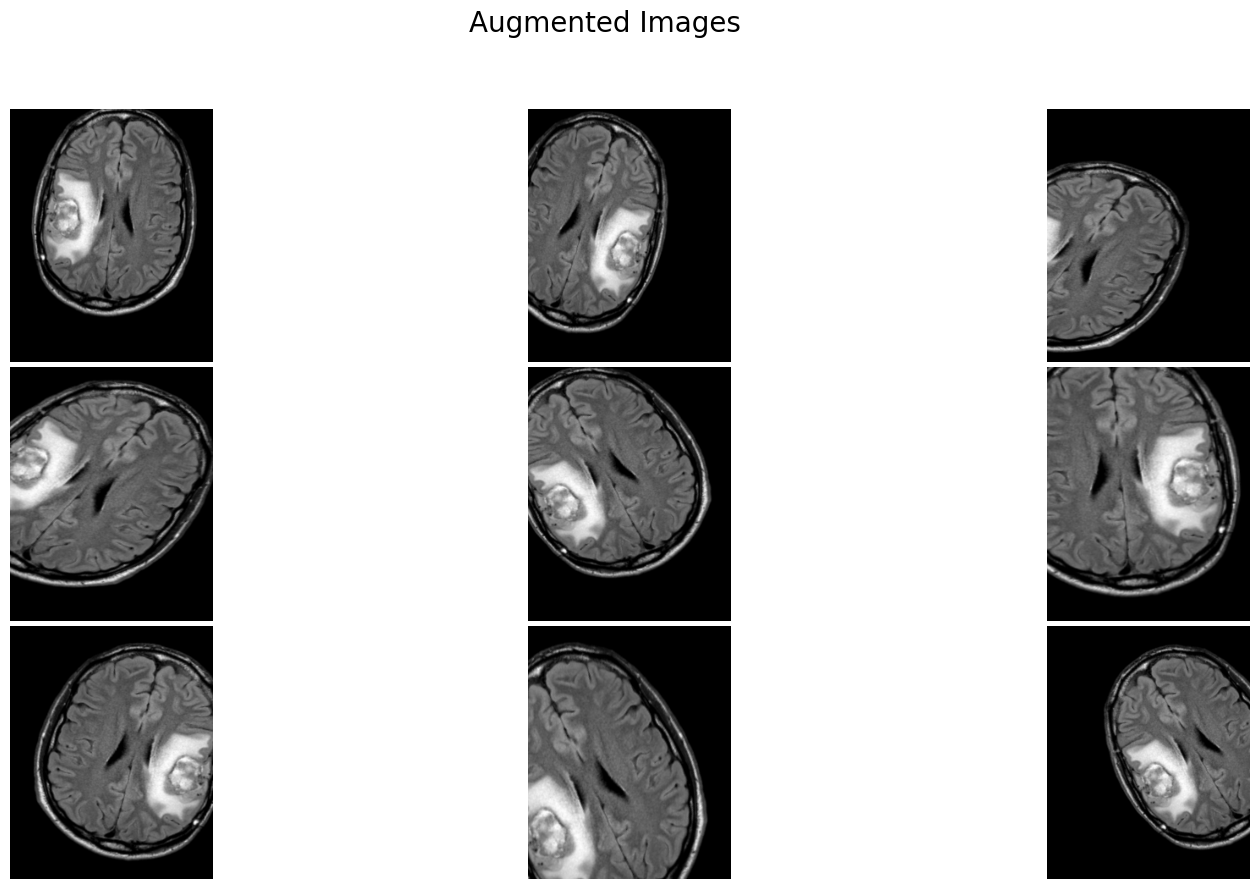

In [31]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

img = load_img('./data/train/yes/Y1.png')  # Replace with the path to your image
x = img_to_array(img)  # This is a Numpy array with shape (3, height, width)
x = x.reshape((1,) + x.shape)  # This is a Numpy array with shape (1, 3, height, width)

# Generate batches of augmented images from this image
aug_iter = datagen.flow(x, batch_size=1)

# Create figure and add a title
plt.figure(figsize=(20,10))
plt.suptitle('Augmented Images', fontsize=20)
plt.subplots_adjust(wspace=0.01, hspace=0.02)

# Plot 9 augmented images
for i in range(9):
    plt.subplot(3, 3, i+1)
    batch = next(aug_iter)
    aug_img = batch[0]
    plt.imshow(aug_img.astype('uint8'))
    plt.axis('off')

plt.show()

## 3.0 CNN Model

To perform the training, I employed the VGG-16 model along with transfer learning. VGG-16 is a deep convolutional neural network architecture that has proven to be highly effective in image classification tasks.

VGG-16 is composed of multiple layers, including convolutional layers, pooling layers, and fully connected layers. The convolutional layers are responsible for extracting meaningful features from the input images, while the pooling layers downsample the feature maps to reduce dimensionality. The fully connected layers at the end of the network perform the classification based on the extracted features.

By utilizing transfer learning, I leveraged the pre-trained weights of the VGG-16 model, which were trained on a large-scale dataset such as ImageNet. This approach allows the model to benefit from the knowledge and representations learned from the massive ImageNet dataset.

During the training process, I fine-tuned the VGG-16 model by adjusting the weights of the network using my own dataset. This enabled the model to specialize in the specific brain image classification task at hand.

By employing VGG-16 with transfer learning, I took advantage of the powerful image representation capabilities of the pre-trained model and adapted it to classify brain images effectively. This approach significantly reduces the training time and enhances the model's ability to generalize and make accurate predictions.

### 3.1 Dataset and Data Augmentation

To address the limited size of my dataset, I utilized Data Augmentation. This technique artificially increases the training set by applying transformations to the existing images, enabling the model to learn from a broader range of variations and improve its performance.

In [44]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

# No specific preprocessing for validation and test data
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    './data/train/',  # replace with the path to your training data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    './data/val/',  # replace with the path to your validation data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    './data/test/',  # replace with the path to your test data directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 176 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


### 3.2 Train Model

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 25088)             0         
                                                                 
 dropout_11 (Dropout)        (None, 25088)             0         
                                                                 
 dense_13 (Dense)            (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 14,739,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 6/12 [==============>...............] - ETA: 3s - loss: 53035.4766 - accuracy: 0.5568

12/12 [==============================] - 10s 300ms/step - loss: 53035.4766 - accuracy: 0.5568 - val_loss: 0.6693 - val_accuracy: 0.6053


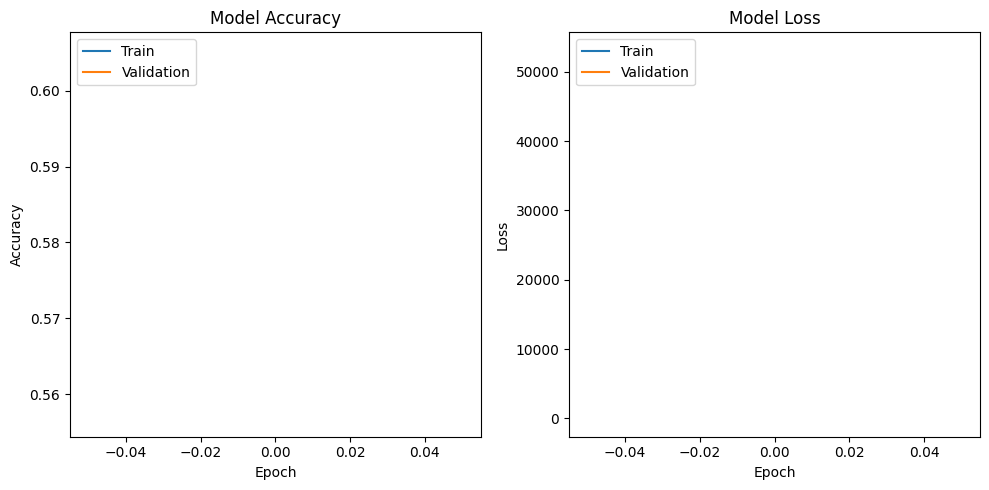

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping

def create_model(input_shape=(224, 224, 3)):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    model = Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

model = create_model()

#
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator)*2,
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[es]
)

model.save_weights('VGG16_weights.h5')

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


2/2 [==============================] - 0s 147ms/step


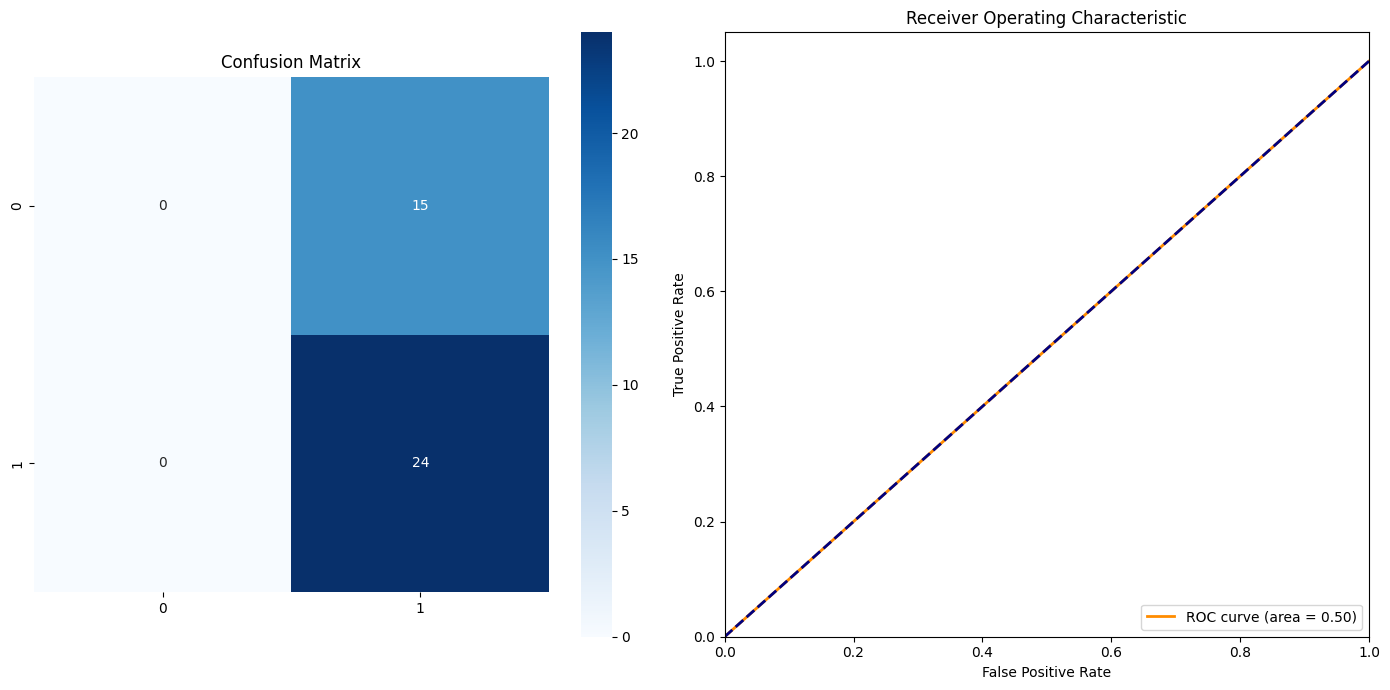

In [50]:
# Load the weights back into the model
model.load_weights('VGG16_weights.h5')

# Generate predictions
y_pred = model.predict(test_generator)
y_pred = y_pred.flatten() > 0.5  # convert probabilities to binary predictions

from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the true labels
y_true = test_generator.classes

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Set up the figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Visualize the confusion matrix
axs[0].imshow(cm, interpolation='nearest', cmap='Blues')
axs[0].set_title('Confusion Matrix')
tick_marks = np.arange(2)
axs[0].set_xticks(tick_marks)
axs[0].set_yticks(tick_marks)
axs[0].set_xlabel('Predicted label')
axs[0].set_ylabel('True label')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[0])

# Plot the ROC curve
axs[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('Receiver Operating Characteristic')
axs[1].legend(loc="lower right")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
